In [2]:
import pennylane as qml
import numpy as np
from matplotlib import pyplot as plt
from pennylane import qaoa as qaoa
import networkx as nx

# Feedback-Based Quantum Optimization (FALQON)

By: David Wakeham and Jack Ceroni

In this demo, we'll be implement the FALQON algorithm, standing for *Feedback-based ALgorithm for Quantum Optimization*, introduced by [Magann, Rudinger, Grace & Sarovar (2021)](https://arxiv.org/pdf/2103.08619.pdf). It is similar in spirit to the [QAOA](https://arxiv.org/pdf/1411.4028.pdf), but scales with resources differently, using iterative feedback steps rather than a global optimization over parameters. We will show how to implement FALQON in PennyLane and test its performance on the **MaxClique** problem in graph theory!

### Theory

To solve combinatorial optimization problems using a quantum computer, a typical strategy is to encode the solution to the problem as the ground state of *cost Hamiltonian* $H_C$, and choose some strategy to drive the system from a known initial state into this ground state. FALQON falls under this broad scheme.

Imagine a quantum system governed by a Hamiltonian of the form $H = H_C + \beta(t) H_D$. These kinds of Hamiltonians come up quite often in the theory of [quantum control](https://quantiki.org/wiki/quantum-control-theory), which studies how we may go about driving a quantum system from one state to another. The choice of $\beta(t)$ allows us to decide which state we want a system governed by such a Hamiltonian to evolve towards. 

The time-dependent Schrodinger equation tells us that the dynamics of the system are given by:

$$
i \frac{d}{dt} |\psi(t)\rangle = (H_C + \beta(t) H_D) |\psi(t)\rangle,
$$

where we set $\hbar = 1$. Now, let us suppose that the objective of our quantum control experiment is to drive our system to the state $|\psi\rangle$: the ground state of $H_C$. Phrased differently, we would like to minimize the expectation value of $\langle H_C\rangle$ (an immediate consequence of the variational principle). Therefore, a reasonable goal is to construct our system such that the expectation decreases with time:

$$
\frac{d}{dt} \langle H_C\rangle_t = \frac{d}{dt} \langle \psi(t)|H_C|\psi(t)\rangle = i \beta(t)\langle [H_D, H_C] \rangle_t \leq 0,
$$

where we used the product rule and Schrödinger's equation. Recall that our control experiment depends on the choice of $\beta(t)$. Thus, if we pick $\beta(t) = -\langle i[H_D, H_C] \rangle_t$, so that

$$
\frac{d}{dt} \langle H_C\rangle_t = -|\langle i[H_D, H_C] \rangle_t|^2 \leq 0.
$$

then $\langle H_C \rangle$ is guaranteed to strictly decrease, as desired!

(Note that we bring the $i$ into the expectation to give a Hermitian operator.)
Using [techniques from control theory](https://arxiv.org/pdf/1304.3997.pdf), it is possible to rigorously show this will eventually drive the system into the ground state! Thus, if we evolve some initial state $|\psi_0\rangle$ under the time-evolution operator corresponding to $H$, given by $U(t) = e^{-iHt}$, then we will arrive at the ground state of $H$! We can approximately discretize $U$ using a Trotter-Suzuki decomposition, so we may implement it on a quantum circuit:

$$
U(t) \approx U_D(\beta_\ell) U_C U_D(\beta_{\ell-1}) U_C\cdots
U_D(\beta_1) U_C, \quad U_C = e^{-iH_C \Delta t}, \quad U_D(\beta_k) =
e^{-i\beta_k H_D \Delta t},
$$

where $\Delta t = t/2\ell$ and $\beta_k = \beta(2k\Delta t)$. One issue remains: for each step, we need to know the value $\beta_k$, which are themselves dependent on the state of the system, at some time. Our strategy is to use the value of $A(t) := i\langle [H_D, H_C] \rangle_t$ obtained by evaluating the circuit for the previous time-step:

$$
\beta_{k+1} = -A_k = -A(2k\Delta t).
$$

This leads immediately to the FALQON algorithm. On step $k$, we perform the following three substeps:

1. Prepare the state $|\psi_k\rangle = U_D(\beta_k) U_C \cdots U_D(\beta_1) U_C|\psi_0\rangle$,
2. Measure the expectation value $A_k = \langle i[H_C, H_D]\rangle_k$.
3. Set $\beta_{k+1} = -A_k$.

### Solving the MaxClique Problem with FALQON

Our goal is to solve the maximum clique (MaxClique) problem: finding the largest complete subgraph of a graph $G$. We begin by defining the graph on which we will perform MaxClique. We will use a graph of the form:

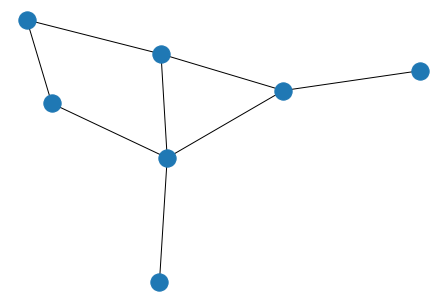

In [36]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3), (1, 4), (4, 5), (5, 2), (0, 6)]
graph = nx.Graph(edges)
nx.draw(graph)

Recall that the cost Hamiltonian corresponding to the MaxClique problem is given by:

$$H_C = 3 \sum_{(i, j) \in E(\bar{G})} (Z_i Z_j - Z_i - Z_j) + \displaystyle\sum_{i \in V(G)} Z_i$$

where $\bar{G}$ is the [complement](https://en.wikipedia.org/wiki/Complement_graph) of the graph $G$. As for $H_D$, we simply must choose a Hamiltonian that does not commute with $H_C$, and effectively "mixes" the state of the system as it is driven towards the desired state. Thus, we choose a simple sum of Pauli-X operations:

$$H_{D} = \displaystyle\sum_{i \in V(G)} X_i$$

We can generate these Hamiltonians easily, using PennyLane QAOA:

In [37]:
cost_h, driver_h = qaoa.max_clique(graph, constrained=False)

print("Cost Hamiltonian")
print(cost_h)
print("Driver Hamiltonian")
print(driver_h)

Cost Hamiltonian
  (-2.75) [Z3]
+ (-2.75) [Z6]
+ (-2.0) [Z4]
+ (-2.0) [Z5]
+ (-1.25) [Z0]
+ (-1.25) [Z1]
+ (-0.5) [Z2]
+ (0.75) [Z0 Z3]
+ (0.75) [Z0 Z4]
+ (0.75) [Z0 Z5]
+ (0.75) [Z1 Z3]
+ (0.75) [Z1 Z5]
+ (0.75) [Z1 Z6]
+ (0.75) [Z2 Z4]
+ (0.75) [Z2 Z6]
+ (0.75) [Z3 Z4]
+ (0.75) [Z3 Z5]
+ (0.75) [Z3 Z6]
+ (0.75) [Z4 Z6]
+ (0.75) [Z5 Z6]
Driver Hamiltonian
  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]
+ (1) [X5]
+ (1) [X6]


As you may recall, one of the main ingredients in the FALQON algorithm is the commutator $[H_D, H_C]$. In the case of MaxClique, we can write down the commutator explicitly, exploiting the bilinearity of the commutator:

$$[H_D, H_C] = \Big[ \displaystyle\sum_{i \in V(G)} X_i, 3 \sum_{(i, j) \in E(\bar{G})} (Z_i Z_j - Z_i - Z_j) + \displaystyle\sum_{i \in V(G)} Z_i \Big] = 3 \Big[ \displaystyle\sum_{i \in V(G)} X_i, \sum_{(i, j) \in E(\bar{G})} (Z_i Z_j - Z_i - Z_j) \Big] + 3 \Big[ \displaystyle\sum_{i \in V(G)} X_i, \displaystyle\sum_{i} Z_i \Big]$$
$$= 3 \displaystyle\sum_{k \in V(G)} \displaystyle\sum_{(i, j) \in E(\bar{G})} \big( [X_k, Z_i Z_j] - [X_k, Z_i] - [X_k, Z_j] \big) + 3 \displaystyle\sum_{i \in V(G)} \displaystyle\sum_{j \in V(G)} [X_i, Z_j]$$

Clearly, there are two distinct commutators that we must calculate, $[X_k, Z_j]$ and $[X_k, Z_i Z_j]$. This is easy, as we know exactly what the [commutators of the Pauli matrices](https://en.wikipedia.org/wiki/Pauli_matrices#Commutation_relations) are. This gives us:

$$[X_k, Z_j] = -2 i \delta_{kj} Y_k \ \ \ \text{and} \ \ \ [X_k, Z_i Z_j] = -2 i \delta_{ik} Y_k Z_j - 2i \delta_{jk} Z_i Y_k$$

Therefore, it follows that:

$$[H_D, H_C] = 6i \displaystyle\sum_{k \in V(G)} \displaystyle\sum_{(i, j) \in E(\bar{G})} \big( \delta_{ki} Y_k + \delta_{kj} Y_k - \delta_{ki} Y_k Z_j - \delta_{kj} Z_{i} Y_{k} \big) - 6i \displaystyle\sum_{i \in V(G)} Y_{i}$$

and the Hermitian operator $i[H_D, H_C]$ is given by:

$$i [H_D, H_C] = 6 \displaystyle\sum_{k \in V(G)} \displaystyle\sum_{(i, j) \in E(\bar{G})} \big( \delta_{ki} Y_k Z_j + \delta_{kj} Z_{i} Y_{k} - \delta_{ki} Y_k - \delta_{kj} Y_k \big) + 6 \displaystyle\sum_{i \in V(G)} Y_{i}$$

This new operator has quite a few terms! Therefore, we can write a short method which computes it for us, and return a `qml.Hamiltonian` object:

In [38]:
def build_commutator(graph):
    
    H = qml.Hamiltonian([], [])
    
    # Computes the complement of the graph
    graph_c = nx.complement(graph)
    
    
    for k in graph_c.nodes:
        # Adds the terms in the first sum
        for edge in graph_c.edges:
            i, j = edge
            if k == i:
                H += 6 * (qml.PauliY(k) @ qml.PauliZ(j) - qml.PauliY(k))
            if k == j:
                H += 6 * (qml.PauliZ(i) @ qml.PauliY(k) - qml.PauliY(k))
        # Adds the terms in the second sum
        H += 6 * qml.PauliY(k)
    
    return H

print("MaxClique Commutator")
print(build_commutator(graph))

MaxClique Commutator
  (-24) [Y3]
+ (-24) [Y6]
+ (-18) [Y4]
+ (-18) [Y5]
+ (-12) [Y0]
+ (-12) [Y1]
+ (-6) [Y2]
+ (6) [Y0 Z3]
+ (6) [Y0 Z4]
+ (6) [Y0 Z5]
+ (6) [Y1 Z3]
+ (6) [Y1 Z5]
+ (6) [Y1 Z6]
+ (6) [Y2 Z4]
+ (6) [Y2 Z6]
+ (6) [Z0 Y3]
+ (6) [Z1 Y3]
+ (6) [Y3 Z4]
+ (6) [Y3 Z5]
+ (6) [Y3 Z6]
+ (6) [Z0 Y4]
+ (6) [Z2 Y4]
+ (6) [Z3 Y4]
+ (6) [Y4 Z6]
+ (6) [Z0 Y5]
+ (6) [Z1 Y5]
+ (6) [Z3 Y5]
+ (6) [Y5 Z6]
+ (6) [Z1 Y6]
+ (6) [Z2 Y6]
+ (6) [Z3 Y6]
+ (6) [Z4 Y6]
+ (6) [Z5 Y6]


Next, we define a single layer of FALQON. This simply consists of one application of each of the layers defined by $H_C$ and $H_D$ in the Trotterized time-evolution:

In [39]:
# Define a layer of the Falqon circuit

def falqon_layer(beta, cost_h, driver_h, delta_t):
    qaoa.cost_layer(delta_t, cost_h)
    qaoa.mixer_layer(delta_t * beta, driver_h)

In [40]:
dev = qml.device("default.qubit", wires=graph.nodes)

In [41]:
# Builds the ansatz

def build_maxclique_ansatz(cost_h, driver_h, delta_t):

    def ansatz(beta, **kwargs):
        layers = len(beta)
        for w in dev.wires:
            qml.Hadamard(wires=w)
        qml.layer(falqon_layer, layers, beta, cost_h=cost_h, driver_h=driver_h, delta_t=delta_t)
    
    return ansatz

In [43]:
def max_clique_falqon(graph, iterations, beta_init, delta_t):
    
    hamiltonian = build_commutator(graph)
    cost_h, driver_h = qaoa.max_clique(graph, constrained=False)
    ansatz = build_maxclique_ansatz(cost_h, driver_h, delta_t)
    
    beta = [beta_init]
    energies = []
    
    for i in range(iterations):
        cost_fn = qml.ExpvalCost(ansatz, hamiltonian, dev)
        cost_fn_energy = qml.ExpvalCost(ansatz, cost_h, dev)
        
        beta.append(-1 * cost_fn(beta))
        energy = cost_fn_energy(beta)
        energies.append(energy)
        
        print("Step {} Done, Cost = {}".format(i, energy))
    
    return beta, energies

res, res_energies = max_clique_falqon(graph, 20, 0.0, 0.02)

Step 0 Done, Cost = -1.5510770003350434
Step 1 Done, Cost = -2.712000184275265
Step 2 Done, Cost = -2.7603216005627367
Step 3 Done, Cost = -3.105907116066205
Step 4 Done, Cost = -3.2756259357576814
Step 5 Done, Cost = -3.4976414370201727
Step 6 Done, Cost = -3.6756804683412825
Step 7 Done, Cost = -3.8350319838147406
Step 8 Done, Cost = -3.964946276361441
Step 9 Done, Cost = -4.073609269301238
Step 10 Done, Cost = -4.165497243243816
Step 11 Done, Cost = -4.245810430536242
Step 12 Done, Cost = -4.317162801764844
Step 13 Done, Cost = -4.382052135544364
Step 14 Done, Cost = -4.441569707292054
Step 15 Done, Cost = -4.497123538805551
Step 16 Done, Cost = -4.549016818526047
Step 17 Done, Cost = -4.598340974219613
Step 18 Done, Cost = -4.6447978362214135
Step 19 Done, Cost = -4.689696307211775


<BarContainer object of 128 artists>

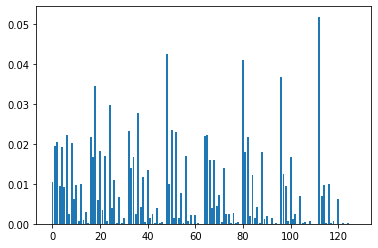

In [44]:
@qml.qnode(dev)
def test_circuit():
    build_maxclique_ansatz(cost_h, driver_h, 0.03)(res)
    return qml.probs(wires=dev.wires)

probs = test_circuit()
plt.bar(range(2**len(dev.wires)), probs)

We can also plot the value of the cost function over time:

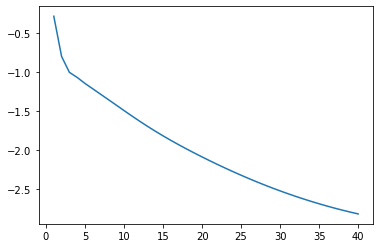

In [33]:
plt.plot(range(41)[1:], res_energies)

### QAOA Seeded By FALQON (Bird Seed)

<center>
    <img src="falqon/falqon.png" style="width:800px;">
</center>

So far, we have described the theory behind FALQON, and implemented a basic example for the MaxClique problem. As was mentioned multiple times through this tutorial, and as you probably noticed yourself, FALQON looks an awful lot like QAOA.

In the following section we will compare QAOA and QAOA seeded by FALQON.

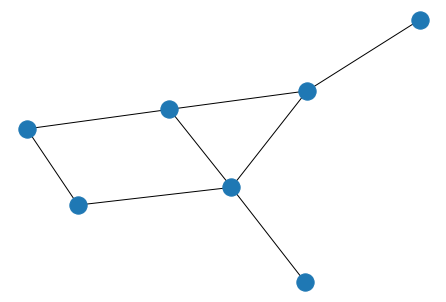

In [45]:
new_edges = [(0, 1), (1, 2), (2, 0), (2, 3), (1, 4), (4, 5), (5, 2), (0, 6)]
new_graph = nx.Graph(new_edges)
nx.draw(new_graph)

In [48]:
depth = 5
dev = qml.device("default.qubit", wires=new_graph.nodes)

cost_h, mixer_h = qaoa.max_clique(new_graph, constrained=False)

def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(beta, mixer_h)

def qaoa_circuit(params, **kwargs):
    for w in dev.wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

cost_fn = qml.ExpvalCost(qaoa_circuit, cost_h, dev)

# Generates the initial parameters:

delta_t = 0.02

print("Running FALQON")
res, res_energy = max_clique_falqon(new_graph, depth-1, 0.0, delta_t)
print("------------------------")

print("Running QAOA")
params = np.array([[delta_t for k in res], [delta_t * k for k in res]])
steps = 40

optimizer = qml.GradientDescentOptimizer()

for s in range(steps):
    params, cost = optimizer.step_and_cost(cost_fn, params)
    print("Step {}, Cost = {}".format(s, cost))

Running FALQON
Step 0 Done, Cost = -1.5510770003350434
Step 1 Done, Cost = -2.712000184275265
Step 2 Done, Cost = -2.7603216005627367
Step 3 Done, Cost = -3.105907116066205
------------------------
Running QAOA
Step 0, Cost = -3.105907116066205
Step 1, Cost = 0.1739166597434483
Step 2, Cost = -5.790355317378425
Step 3, Cost = -6.215572781903979
Step 4, Cost = -6.279976073227648
Step 5, Cost = -6.318748721669104
Step 6, Cost = -6.3204482879895005
Step 7, Cost = -6.247658646338101
Step 8, Cost = -5.815798337706313
Step 9, Cost = -6.034027490770917
Step 10, Cost = -5.109330556980652
Step 11, Cost = -6.5316504132406985
Step 12, Cost = -6.558419916567502
Step 13, Cost = -6.581728781723633
Step 14, Cost = -6.602107817891158
Step 15, Cost = -6.627935548518555
Step 16, Cost = -6.6502056697416885
Step 17, Cost = -6.679899300221044
Step 18, Cost = -6.705828371912222
Step 19, Cost = -6.738522901952355
Step 20, Cost = -6.76730843970261
Step 21, Cost = -6.801836527204581
Step 22, Cost = -6.82910942

[[ 0.1854081   0.17386961  0.37492697  0.44340962  0.50217114]
 [-0.54323266 -0.39383772 -0.29535973 -0.21236118 -0.17169028]]
[3.58265337e-02 1.10503575e-02 1.54520650e-04 9.85964551e-04
 1.48242537e-03 5.81745306e-04 3.14260970e-02 2.42707592e-05
 4.30670555e-03 1.29414826e-03 4.29936658e-04 4.04453014e-03
 1.64728918e-03 5.09289919e-03 1.53963904e-04 1.32265393e-04
 3.25008684e-02 1.08955351e-02 6.49797487e-02 5.83637328e-04
 1.57891020e-02 2.33909984e-03 1.10412668e-02 2.32372564e-04
 2.66259641e-02 1.04310838e-04 7.84863834e-03 6.76991800e-04
 6.99903108e-04 2.40961016e-05 2.64497839e-04 1.79517114e-04
 6.14040178e-03 2.15441787e-03 5.86228963e-03 9.90130311e-04
 4.60331346e-02 9.94995527e-05 7.24929783e-03 5.96802470e-05
 2.65863201e-03 1.58808541e-03 4.16114191e-05 1.76338239e-03
 6.96422266e-05 1.66315555e-04 2.68794044e-04 1.50693076e-04
 1.93468559e-02 1.81084834e-03 2.58218276e-02 3.14097084e-04
 1.92678394e-02 7.02270215e-04 1.20168453e-02 1.56251779e-03
 1.77007011e-02 5.5

<BarContainer object of 128 artists>

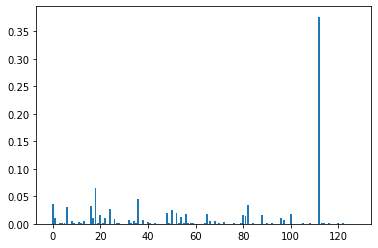

In [49]:
print(params)

@qml.qnode(dev)
def test_circuit():
    qaoa_circuit(params)
    return qml.probs(wires=dev.wires)

probs = test_circuit()
print(probs)
plt.bar(range(2**len(dev.wires)), probs)